In [9]:
import torch_hydramp_models


In [10]:
#!pip install torch==2.3.1+cu121

In [11]:
decoder = torch_hydramp_models.HydrAMPDecoderTORCH()
encoder = torch_hydramp_models.HydrAMPEncoderTorch()

In [14]:
import torch

decoder.load_state_dict(torch.load('./weights/decoder_weights.pickle'))
encoder.load_state_dict(torch.load('./weights/encoder_weights.pickle'))

<All keys matched successfully>

In [15]:
def decoder_forward(x, temp=0.1):
    return torch.softmax(decoder(x.view(1, -1) / temp), dim=-1).view(1, -1)

In [16]:
#def decoder_forward(x):
#    return torch.stack([
#        torch.sin(x[0]) * torch.cos(x[1]), torch.sin(x[0]) * torch.sin(x[1]), torch.cos(x[0])
#    ]).view(1, -1)

In [17]:
def decoder_jacobian(x):
    return torch.func.jacrev(decoder_forward)(x)

In [18]:
def decoder_forward_dd(x, v, s):
    return decoder_forward(x + s * v)

In [19]:
def decoder_jacobian_forward(x, direction):
    jacobian = torch.func.jacrev(decoder_forward)(x)
    x_rev_result = torch.matmul(jacobian, direction)
    return x_rev_result, jacobian

In [20]:
def decoder_jacobian_forward_nj(x, direction):
    jacobian = torch.func.jacrev(decoder_forward)(x)
    x_rev_result = torch.matmul(jacobian, direction)
    return x_rev_result

In [21]:
def double_direction_forward(x, direction):
    double_jac, jacobian = torch.func.jacrev(
       decoder_jacobian_forward, argnums=0, has_aux=True,
    )(x, direction)
    x_rev_result = torch.matmul(double_jac, direction)
    return x_rev_result, jacobian

In [22]:
def decoder_jacobian_trick(x, direction):
    jacobian, vec = torch.func.jacrev(
        decoder_forward_dd, argnums=(0, 2))(x, direction, torch.zeros((1,)))
    return vec, jacobian

In [23]:
def double_direction_forward_trick(x, direction):
    result, jacobian = torch.func.jacrev(
        decoder_jacobian_trick, argnums=0, has_aux=True)(x, direction)
    return result, jacobian

In [24]:
def field_derivative(x, direction, eps=0.1):
    right = decoder_forward(x + eps * direction)
    left = decoder_forward(x - eps * direction)
    center = decoder_forward(x)
    return (right + left - 2 * center) / eps ** 2

In [25]:
def sample_sphere_tensor(size):
    normal = torch.normal(0, 1, (size,))
    norm = torch.sum(normal ** 2) ** 0.5
    return normal / norm

In [26]:
def to_one_hot(x, pad=26):
    alphabet = list(' ACDEFGHIKLMNPQRSTVWY')
    classes = range(0, 21)
    aa_encoding = dict(zip(alphabet, classes))
    if len(x) > 25:
        x = x[:25]
    else:
        x = x + ''.join([' ' * (25 - len(x))])
    return [aa_encoding[aa] for aa in x]

PEXIGANAN = 'GQLNKFIKKAQRKFHEKFAK'
# GQLNKFIKKAQRKFHEKFAK


seq = torch.tensor([to_one_hot(PEXIGANAN)])

pexi_mean, pexi_std = encoder(seq)

starting_point = torch.cat([pexi_mean[0], torch.ones((2,))])

In [27]:
#starting_point = torch.ones((2,)) * 0.1

In [28]:
EPS = 5e-1
MAX_TIME = 1
THRESHOLD = 0.5
MAX_UPDATE_NORM = 1e-1
NB_OF_TRAJECTORIES = 200

In [29]:
trajectories, times = [], []

In [ ]:
import tqdm
import numpy
from scipy.optimize import root_scalar


for _ in tqdm.tqdm(range(NB_OF_TRAJECTORIES)):
    current_point = starting_point
    trajectory = [current_point]
    current_times = [0]
    time = 0
    while time < MAX_TIME:
        current_jacobian = decoder_jacobian(current_point)[0]
        #print(current_jacobian)
        U, S, V = torch.svd(current_jacobian)
        S_abs = torch.abs(S)
        #print(S)
        dim = torch.sum(S_abs > THRESHOLD)
        anti_dim = torch.sum(S_abs <= THRESHOLD)
        trunc_s = S[S_abs > THRESHOLD]
        
        trunc_s_jac = torch.Tensor(S)
        trunc_s_jac[S <= THRESHOLD] = 0
        
        trunc_s_anti = torch.Tensor(S)
        trunc_s_anti[S > THRESHOLD] = 0
        
        trunc_v = V[:, S_abs > THRESHOLD]
        #trunc_u = U[:, S_abs > THRESHOLD]
        trunc_jac = torch.matmul(torch.matmul(U, torch.diag(trunc_s_jac)), V.T)
        #print(torch.norm(trunc_jac - current_jacobian))
        euc_sphere_sample = sample_sphere_tensor(dim)
        anti_euc_sphere_sample = sample_sphere_tensor(anti_dim)

        riem_sphere_sample = euc_sphere_sample / trunc_s
        riem_sphere_sample_h = torch.zeros_like(S)
        riem_sphere_sample_h[S_abs > THRESHOLD] = riem_sphere_sample
        direction_sample = torch.matmul(riem_sphere_sample_h, V.T) * EPS #/ (dim ** 0.5)

        anti_riem_sphere_sample = anti_euc_sphere_sample
        anti_riem_sphere_sample_h = torch.zeros_like(S)
        anti_riem_sphere_sample_h[S_abs <= THRESHOLD] = anti_riem_sphere_sample
        anti_direction_sample = torch.matmul(anti_riem_sphere_sample_h, V.T) * EPS

        field_acc = field_derivative(current_point, direction_sample)
        acc = torch.matmul(torch.linalg.pinv(trunc_jac), field_acc[0])
        #print(torch.norm(direction_sample), torch.norm(acc), torch.norm(field_acc))
        
        update = direction_sample - 0.5 * acc
        if torch.isnan(torch.norm(update)):
            print('NAN')
            break
        update_norm = torch.norm(update)
        if update_norm > MAX_UPDATE_NORM:
            dir_numpy = direction_sample.cpu().detach().numpy() / EPS 
            acc_numpy = acc.cpu().detach().numpy() / EPS ** 2
        
            dir_norm_squared = numpy.linalg.norm(dir_numpy) ** 2
            acc_norm_squared = numpy.linalg.norm(acc_numpy) ** 2
            dot_ = numpy.dot(dir_numpy, acc_numpy)
            
            def _root_fun(s):
                return 0.25 * acc_norm_squared * s ** 4 - dot_ * s ** 3 + dir_norm_squared * s ** 2 - MAX_UPDATE_NORM ** 2
            
            s = root_scalar(_root_fun, bracket=(0, 1)).root
            
            update = torch.tensor(dir_numpy * s - 0.5 * acc_numpy ** s ** 2)
            print(torch.norm(update), s)
            time += s ** 2
        else:
            time += EPS ** 2
        full_update = update + anti_direction_sample
        print(
            torch.norm(direction_sample),
            torch.norm(acc), 
            torch.norm(field_acc), 
            torch.norm(anti_direction_sample), 
            time,
            dim,
        )
        next_point = current_point + update
        trajectory.append(next_point)
        current_point = next_point
        current_times.append(float(time))
    trajectories.append(trajectory)
    times.append(current_times)


/home/marmarmarmar/hydramp/hydramp/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
  0%|                                                                                                                                                                               | 0/200 [00:00<?, ?it/s]

tensor(0.1000) 0.2517409243065562
tensor(0.1986, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(4.1625, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.06337349297071926 tensor(10)
tensor(0.1000) 0.10029632378675284
tensor(0.4985, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(25.9576, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.07343284553585643 tensor(11)
tensor(0.1000) 0.35029909294468997
tensor(0.1427, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.2441, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.19614230005372896 tensor(12)
tensor(0.1000) 0.15082263667858986
tensor(0.3315, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(10.3580, grad_fn=<LinalgVectorNormBackward0>) te

  0%|▊                                                                                                                                                                    | 1/200 [00:46<2:34:14, 46.50s/it]

tensor(0.1000) 0.2145665771298174
tensor(0.2330, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.4766, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0014000593018133 tensor(14)
tensor(0.1000) 0.13909124025805955
tensor(0.3595, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(17.1215, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.019346373116525244 tensor(10)
tensor(0.1000) 0.1276888830437557
tensor(0.3916, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(19.5616, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.03565082396948717 tensor(10)
tensor(0.1000) 0.3651434307238175
tensor(0.1369, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.1339, grad_fn=<LinalgVectorNormBackward0>) tens

  1%|█▋                                                                                                                                                                   | 2/200 [01:41<2:50:25, 51.64s/it]

tensor(0.1000) 0.14761781160989512
tensor(0.3387, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.6834, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0176545774327423 tensor(16)
tensor(0.1000) 0.22622962314516212
tensor(0.2210, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(12.4552, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.05117984238840207 tensor(10)
tensor(0.1000) 0.3334832932030174
tensor(0.1499, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(5.8208, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.16239094923393174 tensor(10)
tensor(0.1000) 0.1494434445747534
tensor(0.3346, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(10.9678, grad_fn=<LinalgVectorNormBackward0>) tens

  2%|██▍                                                                                                                                                                  | 3/200 [02:22<2:33:00, 46.60s/it]

tensor(0.1000) 0.24687995258170076
tensor(0.2025, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.1001, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0010340940360523 tensor(13)
tensor(0.1000) 0.3480703629590004
tensor(0.1436, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(5.6345, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.12115297757041028 tensor(10)
tensor(0.1000) 0.20887081362729926
tensor(0.2394, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(6.1713, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.16477999435574026 tensor(16)
tensor(0.1000) 0.4496990831639088
tensor(0.1112, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.6888, grad_fn=<LinalgVectorNormBackward0>) tensor

  2%|███▎                                                                                                                                                                 | 4/200 [03:06<2:29:17, 45.70s/it]

tensor(0.1000) 0.32914614679627135
tensor(0.1519, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.9482, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0672873062335853 tensor(15)
tensor(0.1000) 0.339748263082909
tensor(0.1472, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(6.5639, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.11542888226785356 tensor(10)
tensor(0.1000) 0.22439777052311427
tensor(0.2228, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.3938, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.16578324168359782 tensor(16)
tensor(0.1000) 0.13313485171926803
tensor(0.3756, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(14.3755, grad_fn=<LinalgVectorNormBackward0>) tenso

  2%|████▏                                                                                                                                                                | 5/200 [03:57<2:34:23, 47.50s/it]

tensor(0.1000) 0.15535438854982175
tensor(0.3218, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(10.4046, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0096105690090156 tensor(21)
tensor(0.1000) 0.13817691672190954
tensor(0.3619, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(15.1839, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.019092860314773526 tensor(10)
tensor(0.1000) 0.09932083585416272
tensor(0.5034, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(59.0830, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.028957488749543063 tensor(10)
tensor(0.1000) 0.3162748628250615
tensor(0.1581, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.0087, grad_fn=<LinalgVectorNormBackward0>) 

  3%|████▉                                                                                                                                                                | 6/200 [04:35<2:23:34, 44.40s/it]

tensor(0.0830, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.0059, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.1915160752592011 tensor(8)
tensor(0.1000) 0.329359799304539
tensor(0.1518, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(5.4383, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.10847787739792622 tensor(10)
tensor(0.1000) 0.21933606102114428
tensor(0.2280, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(16.1436, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.15658618506219735 tensor(15)
tensor(0.1000) 0.18081526946269114
tensor(0.2765, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(6.2456, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormB

  4%|█████▊                                                                                                                                                               | 7/200 [05:23<2:26:29, 45.54s/it]

tensor(0.1000) 0.14726129726751058
tensor(0.3395, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(11.8951, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.017288902604739 tensor(17)
tensor(0.1000) 0.20794649806433788
tensor(0.2404, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(20.9703, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.043241746057221676 tensor(10)
tensor(0.1000) 0.24948926144496242
tensor(0.2004, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(3.2254, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.10548663763357449 tensor(10)
tensor(0.1000) 0.09949075762499385
tensor(0.5026, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(72.9980, grad_fn=<LinalgVectorNormBackward0>) t

  4%|██████▌                                                                                                                                                              | 8/200 [06:17<2:33:54, 48.09s/it]

tensor(0.1000) 0.21989284408540977
tensor(0.2274, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(3.0928, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0230718343069767 tensor(18)
tensor(0.1000) 0.15596550861183495
tensor(0.3206, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(8.8330, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.02432523987654836 tensor(10)
tensor(0.1000) 0.41028827962435604
tensor(0.1219, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.9013, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.19266171227366213 tensor(8)
tensor(0.1000) 0.2356134968826534
tensor(0.2122, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(7.7968, grad_fn=<LinalgVectorNormBackward0>) tensor

  4%|███████▍                                                                                                                                                             | 9/200 [06:58<2:26:41, 46.08s/it]

tensor(0.1000) 0.35481267043651404
tensor(0.1409, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(0.7957, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.084502716874831 tensor(16)
tensor(0.1000) 0.3116539851239476
tensor(0.1604, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.0006, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.09712820644363775 tensor(10)
tensor(0.1000) 0.19571805623686517
tensor(0.2555, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(12.3416, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.13543376398077445 tensor(11)
tensor(0.1000) 0.16747062913224442
tensor(0.2986, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(11.3742, grad_fn=<LinalgVectorNormBackward0>) tens

  5%|████████▏                                                                                                                                                           | 10/200 [07:29<2:11:16, 41.45s/it]

tensor(0.1000) 0.434923489175886
tensor(0.1150, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.0804, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.1430083963313473 tensor(17)
tensor(0.1000) 0.3336220564352315
tensor(0.1499, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.9744, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.11130367654007281 tensor(10)
tensor(0.1000) 0.2243510041741336
tensor(0.2229, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.1183, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.16163704961401493 tensor(10)
tensor(0.1000) 0.2981118728716802
tensor(0.1677, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.2728, grad_fn=<LinalgVectorNormBackward0>) tensor(0.

  6%|█████████                                                                                                                                                           | 11/200 [08:23<2:22:41, 45.30s/it]

tensor(0.1000) 0.20889349134036464
tensor(0.2394, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.7196, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0301687930000156 tensor(15)
tensor(0.1000) 0.16647103900622745
tensor(0.3004, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(14.8030, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.027712606827812902 tensor(10)
tensor(0.1000) 0.27644838998939086
tensor(0.1809, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(8.0113, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.10413631915553924 tensor(15)
tensor(0.1000) 0.18026567059266196
tensor(0.2774, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(8.6278, grad_fn=<LinalgVectorNormBackward0>) te

  6%|█████████▊                                                                                                                                                          | 12/200 [09:17<2:29:39, 47.76s/it]

tensor(0.1000) 0.13710574535712167
tensor(0.3647, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.0373, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0078990889641963 tensor(17)
tensor(0.1000) 0.3278277786158292
tensor(0.1525, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(13.6444, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.1074710524321891 tensor(10)
tensor(0.1000) 0.27608699730416614
tensor(0.1811, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(4.8785, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.18369508251261973 tensor(11)
tensor(0.1000) 0.23158986111387542
tensor(0.2159, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(10.0073, grad_fn=<LinalgVectorNormBackward0>) tens

  6%|██████████▋                                                                                                                                                         | 13/200 [10:30<2:52:30, 55.35s/it]

tensor(0.1000) 0.27377474243891897
tensor(0.1826, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.4333, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0745549741270486 tensor(18)
tensor(0.1000) 0.18777235706842965
tensor(0.2663, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(20.6632, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.03525845807903384 tensor(10)
tensor(0.1000) 0.09262527466474098
tensor(0.5398, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(56.3441, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.04383789958575255 tensor(11)
tensor(0.1000) 0.15498080385563706
tensor(0.3226, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(5.2214, grad_fn=<LinalgVectorNormBackward0>) te

  7%|███████████▍                                                                                                                                                        | 14/200 [11:33<2:59:08, 57.78s/it]

tensor(0.1000) 0.1700067284385953
tensor(0.2941, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(3.6952, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0288643893958327 tensor(19)
tensor(0.1000) 0.24222983138109028
tensor(0.2064, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(14.7520, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.058675291210911425 tensor(10)
tensor(0.1000) 0.17094348646657803
tensor(0.2925, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(5.0201, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.08789696677626058 tensor(12)
tensor(0.1000) 0.12633360165480806
tensor(0.3958, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(5.7440, grad_fn=<LinalgVectorNormBackward0>) ten

  8%|████████████▎                                                                                                                                                       | 15/200 [12:12<2:40:46, 52.14s/it]

tensor(0.1000) 0.37294856201463766
tensor(0.1341, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(1.0179, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.1365229883428143 tensor(15)
tensor(0.1000) 0.4025015616617185
tensor(0.1242, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(6.1903, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.1620075071401222 tensor(10)
tensor(0.1000) 0.1259128583464433
tensor(0.3971, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(16.8837, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.1778615550370937 tensor(12)
tensor(0.1000) 0.166536029666196
tensor(0.3002, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(17.3980, grad_fn=<LinalgVectorNormBackward0>) tensor(0

  8%|█████████████                                                                                                                                                       | 16/200 [12:45<2:22:25, 46.45s/it]

tensor(0.0873, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(0.4489, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0208259730560103 tensor(12)
tensor(0.1000) 0.195024129813234
tensor(0.2564, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(12.8735, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.03803441120940915 tensor(10)
tensor(0.1000) 0.21140802332089415
tensor(0.2365, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(5.5719, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.08272776353385687 tensor(11)
tensor(0.1000) 0.1653248561543423
tensor(0.3024, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(2.4486, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormB

  8%|█████████████▉                                                                                                                                                      | 17/200 [13:36<2:25:54, 47.84s/it]

tensor(0.1000) 0.1646766991507183
tensor(0.3036, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(3.3202, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 1.0119838458326036 tensor(17)
tensor(0.1000) 0.30833980715456033
tensor(0.1622, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(4.2849, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.09507343667611146 tensor(10)
tensor(0.1000) 0.4092936293292162
tensor(0.1222, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(6.1633, grad_fn=<LinalgVectorNormBackward0>) tensor(0.5000, grad_fn=<LinalgVectorNormBackward0>) 0.2625947116855933 tensor(8)
tensor(0.1000) 0.21144844288649453
tensor(0.2365, grad_fn=<LinalgVectorNormBackward0>) tensor(0., grad_fn=<LinalgVectorNormBackward0>) tensor(45.4721, grad_fn=<LinalgVectorNormBackward0>) tensor(

In [162]:
import numpy


tracs_arrays = [
    numpy.array(
        [   el.cpu().detach().numpy()
            for el in trajectory
        ]
    )
    for trajectory in trajectories
]

In [163]:
for trac_array in tracs_arrays:
    print(trac_array.shape)

(14, 66)
(22, 66)
(23, 66)
(17, 66)
(13, 66)
(14, 66)
(21, 66)
(13, 66)
(25, 66)
(26, 66)
(30, 66)
(19, 66)
(18, 66)
(16, 66)
(30, 66)
(23, 66)
(19, 66)
(23, 66)
(17, 66)
(20, 66)
(26, 66)
(23, 66)
(19, 66)
(22, 66)
(21, 66)
(17, 66)
(18, 66)
(15, 66)
(19, 66)
(19, 66)
(21, 66)
(13, 66)
(23, 66)
(16, 66)
(19, 66)
(20, 66)
(14, 66)
(20, 66)
(22, 66)
(24, 66)
(24, 66)
(21, 66)
(19, 66)
(27, 66)
(26, 66)
(20, 66)
(24, 66)
(21, 66)
(19, 66)
(30, 66)
(23, 66)
(22, 66)
(32, 66)
(16, 66)
(18, 66)
(18, 66)
(15, 66)
(19, 66)
(25, 66)
(14, 66)
(17, 66)
(24, 66)
(15, 66)
(18, 66)
(24, 66)
(23, 66)
(26, 66)
(14, 66)
(23, 66)
(17, 66)
(22, 66)
(27, 66)
(13, 66)
(29, 66)
(18, 66)
(28, 66)
(19, 66)
(24, 66)
(23, 66)
(23, 66)
(18, 66)
(25, 66)
(28, 66)
(32, 66)
(14, 66)
(20, 66)
(20, 66)
(24, 66)
(23, 66)
(18, 66)
(22, 66)
(27, 66)
(14, 66)
(18, 66)
(22, 66)
(28, 66)
(21, 66)
(17, 66)
(19, 66)
(23, 66)
(24, 66)
(31, 66)
(17, 66)
(18, 66)
(21, 66)
(31, 66)
(23, 66)
(33, 66)
(20, 66)
(15, 66)
(12, 66)
(

In [164]:
tracs_inds = []
times_inds = []

for ind_, trac_array in enumerate(tracs_arrays):
    tracs_inds.extend([ind_] * trac_array.shape[0])
    times_inds.extend(range(trac_array.shape[0]))

In [165]:
all_trajectories_comb = numpy.concatenate(tracs_arrays)

In [166]:
all_times = numpy.concatenate(times)

In [167]:
all_times = numpy.concatenate(times)

In [168]:
encodings = numpy.array([
    decoder_forward(el).cpu().detach().numpy()[0]
    for el in trajectory
])

In [169]:
all_trajectories_comb.shape

(4952, 66)

In [170]:
from sklearn.decomposition import PCA

trajectory_decompose = PCA()
trajectory_decomposition = trajectory_decompose.fit_transform(all_trajectories_comb)

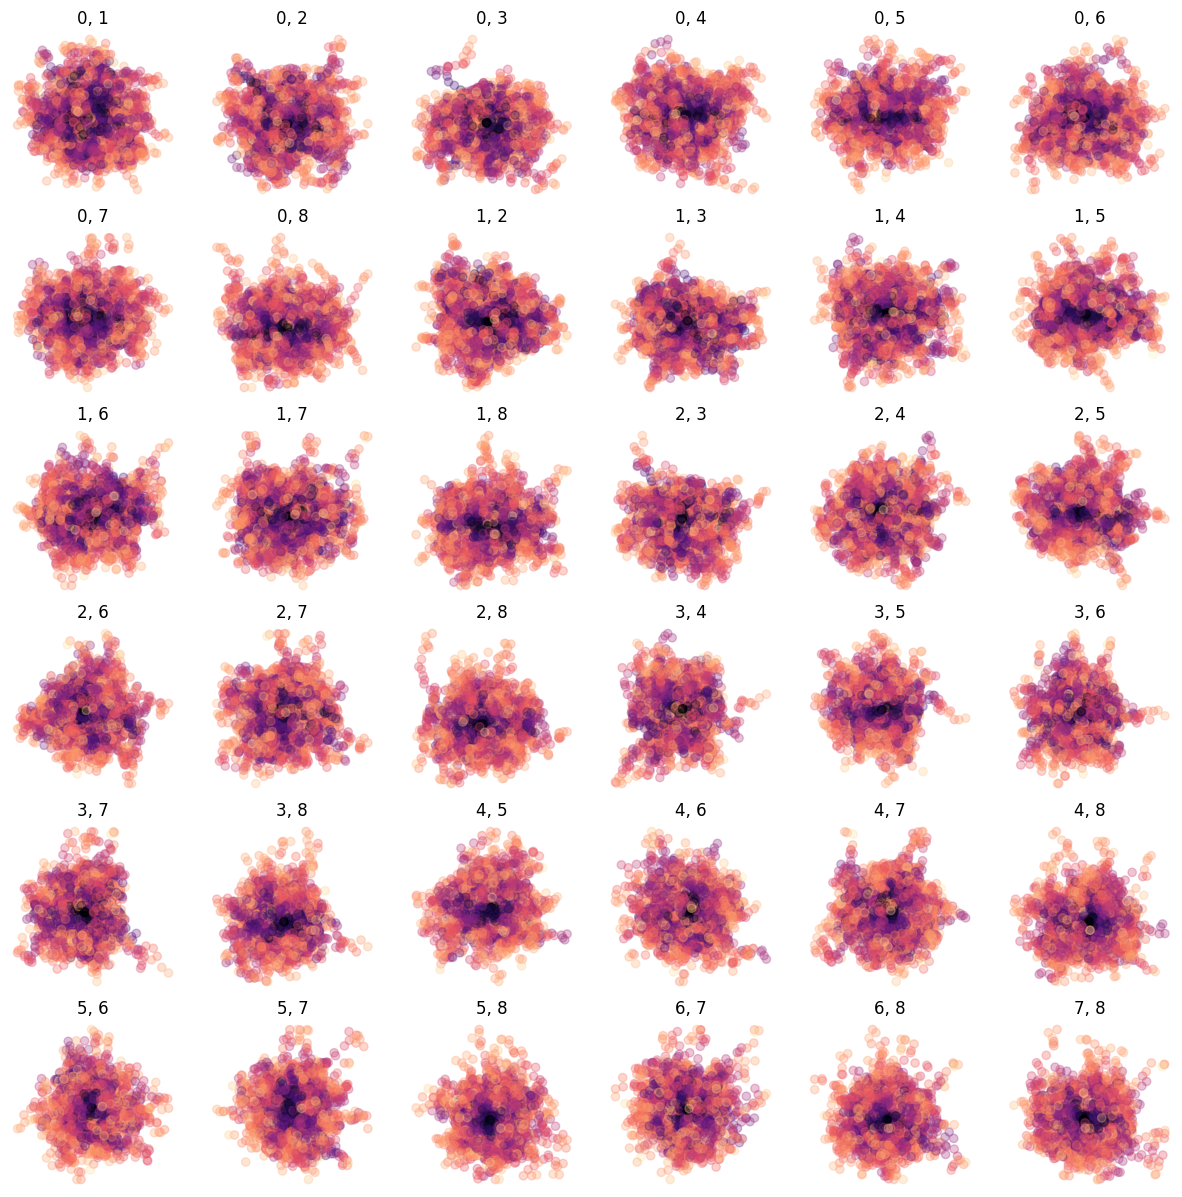

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

current_plot = 1
for i in range(9):
    for j in range(i + 1, 9):
        plt.subplot(6, 6, current_plot)
        plt.title(f'{i}, {j}')
        plt.scatter(
            trajectory_decomposition[:, i], 
            trajectory_decomposition[:, j],
            c=all_times,
            alpha=0.3,
            cmap='magma',
        )
        plt.axis('off')
        current_plot += 1

In [172]:
trajectory_tensor = torch.tensor(all_trajectories_comb)

In [173]:
def translate_generated_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el - 1] if el != 0 else "" for el in encoded_peptide[0].argmax(axis=1)])

In [174]:
predicted_peptides = decoder(trajectory_tensor)

In [175]:
#!pip install levenshtein

In [176]:
import Levenshtein

In [177]:
distance_from_center = []
all_peptides = []

predicted_peptides_strings = [(PEXIGANAN, 0, 0)]
for predicted_peptide, time_ in zip(predicted_peptides, all_times):
    translated_peptide = translate_generated_peptide(predicted_peptide.view(1, 25, 21))
    print(translated_peptide,
          Levenshtein.distance(translated_peptide, PEXIGANAN),
          Levenshtein.distance(translated_peptide, predicted_peptides_strings[-1][0]),
          time_
         )
    if translated_peptide in all_peptides:
        continue
    all_peptides.append(translated_peptide)
    distance_from_center.append(Levenshtein.distance(translated_peptide, PEXIGANAN))
    predicted_peptides_strings.append(
        (translated_peptide, Levenshtein.distance(translated_peptide, PEXIGANAN), time_))

GQLNKFIKKAQRKFHEKFAK 0 0 0.0
GQLNKFIKKAQRKFHEKFAK 0 0 0.015312576678499432
GQLNKFIKKAQRKFHEKFAK 0 0 0.10819657962734923
GQLNKFIKKAQRKFFEKFAK 1 1 0.24224592529723132
GQLNKFIKKAQRKFFEKFAK 1 0 0.29119521535771087
GQLNKFIKKAQRKFFEKFAK 1 0 0.3084999012328372
GQLNKFIKKAWRKFFEKFAK 2 1 0.5584999012328372
GQLNKFIKKAWRKFFEKFAK 2 0 0.6349578648919112
GQLNKFIKKAWRKYFEKFAK 3 1 0.6812898525420648
GQLNKFIKKAWRKYFEKFAK 3 0 0.8092810600041537
GQLNKFIKKAWRKYFEKHLK 5 2 0.8575399807966777
GQLKKFIKKAWRKYFEKFAK 4 3 0.8749233096845788
GQLKKPIKKAWRKYFEKFAK 5 1 0.9011911169533419
GQLKKFIKKAWRKYFEKFAK 4 1 1.028566615348909
GQLNKFIKKAQRKFHEKFAK 0 5 0.0
GQLNKFIKKAQRKFHEKFAK 0 5 0.06988301499487232
GQLNKFIKKAQRKFVEKFAK 1 5 0.0961391787484919
GQLNKFIKKAQRKFHEKFLK 1 2 0.13377597503594194
GQLNKFIKKAQRKFHEKFLK 1 0 0.1547943324601597
GQLNKFIKKAQRKFHEKFLK 1 0 0.24325861008895422
GQLNKFIKKAQRKFHEKFLK 1 0 0.3061706773921845
GQLNKFIKKAQRKFHEKFSK 1 1 0.3241533807405445
GQLNKFIKKAQRKFHEKFLK 1 1 0.3433049195915202
GQLNKFIKKAQ

GQLNKFIKKAQRKFHEKFAK 0 2 0.0
GQLNKFIKKAQRKFHEKFAK 0 2 0.024798974903491307
GQLNKFIKKAQRKFHEKFAK 0 2 0.07358765937492034
GQLNKFIKKAQRKFHEKFAK 0 2 0.09947616408894662
GQLNKFIKKAQRKFHEKFAK 0 2 0.10627033544752057
GQLNKFIKKAQRKFHEKFAK 0 2 0.1222833470463394
GQLNKFIKKAQRKFHEKFAK 0 2 0.3722833470463394
GQLNKFIKKAQRKFHEKFSK 1 2 0.4243983671130873
GQLNKFIKKAQRKFHEKFSK 1 2 0.4601614546916242
GQLNKFIKKAQRKFHEKFSK 1 2 0.4794032936096652
GQLNKFIKKAQRKFHEKFSK 1 2 0.4902886957077117
GQLNKFIKKAQRKFHEKFSN 2 3 0.5080226066957838
GQLKKFIKKAQRKFHEKFVN 3 2 0.5547427786770677
GQLKKFIKKAQRKFFEKFVLK 4 3 0.6290403789662051
GQLKKFIKKAQRKFFEKFVLK 4 0 0.6518015457757322
GQLKKFIKKAQRKFFEKFVLK 4 0 0.7171547191923506
GQLKKFIKKAQRKFFEKIVEK 5 2 0.7430604531553016
GQLKKFIKKAQQKFFEKIVEK 6 1 0.787208831178197
GQLKKFIKKAQQKFFEKIVEK 6 0 0.8157482241857776
GQLKKFIKKAQQKFFEKIVEK 6 0 0.8235495270882504
GQLNKFIKKAQQKFFEKIVDK 5 2 0.8324201506240176
GQLNKFIKKAQQKFFEKISL 5 3 0.8600384015397942
GQLNKFIKKAQQKFFEKIVEK 5 3 0.8794008

GQLNKFIKKAQRKYFEKFAK 2 0 0.37441674905892436
GQLNKFIKKAQRKYFEKFAW 3 1 0.40210390507207766
GQLNKFIKKAQRKYFEKFAW 3 0 0.42190942699572065
GQLNKFIKKAQRKYFEKFAW 3 0 0.48416156685881717
GQLNKFIKKAQRKYFEKFAW 3 0 0.5343566794461444
GQLNKFIKKAQRKYFEKFAW 3 0 0.5422593676718249
GQLNKFIKKAQRKYFEKFAW 3 0 0.5988672562167079
GQLNKFIKKAQRKYFEKFAW 3 0 0.6323125421130992
GQLNKFIKKAQRKYCEKFAW 3 1 0.6514993103031177
GQLNKFIKKARRKYFEKFAW 4 2 0.7133720463607433
GQLNKFIKKARRKYFEKFAW 4 0 0.7414571773071976
GQLNKFIKKAQRKYCEKFAW 3 2 0.7866705100157648
GQLNKFIKKAQRKYCEKFGW 4 3 0.849166606094408
GQLNKFIKKAQRKYHEKFGW 3 1 0.8789618312143157
GQLNKFIKKAQRKYHEKFVK 2 2 0.9176587019519362
GQLNKFIKKAQRKFHEKFGK 1 2 0.934786511268674
GQLNKFIKKAQRKYFEKFVK 3 1 0.9815006947495803
GQLNKFIKKAQRKYHEKFGK 2 2 1.0032829535073187
GQLNKFIKKAQRKFHEKFAK 0 2 0.0
GQLNKFIKKAQRKFHEKFAK 0 2 0.06889783884925287
GQLNKFIKKAQRKFVEKFAK 1 3 0.10103421191622061
GQLNKFIKKAQRKFVEKFAK 1 3 0.11935866852417715
GQLNKFIKKAQRKFHEKFAK 0 2 0.265288540377201

GQLNKFIKKARRKFHEKFDK 2 1 0.5829332334099329
GQLNKFIKKARRKFHEKFAK 1 2 0.6155258147350035
GQLNKFIKKARRKFHEKFAK 1 2 0.628988939037193
GQLNKFIKKARRKFHEKFSK 2 2 0.7164172055576284
GQLNKFIKKARRKFHEKFSK 2 2 0.7298270875371675
GQLNKFIKKARRKFHEKFAK 1 2 0.7419278452824962
GQLNKFIKKARRKFHEKFSK 2 2 0.7840639537528479
GQLNKFIKKARRKFHEKFSK 2 2 0.8132976915376635
GQLNKFIKKARRKFHEKFDK 2 1 0.8639844079545433
GQLNKFIKKARRKFHEKFSK 2 2 0.914712695078221
GQLNKFIKKARRPFHEKFSK 3 3 1.129797092067458
GQLNKFIKKAQRKFHEKFAK 0 3 0.0
GQLNKFIKKAQRKFHEKFAK 0 3 0.054155612883379264
GQLNKFIKKAQRKFHEKFAK 0 3 0.07244803951915033
GQLNKFIKKAQRKFIEKFAK 1 4 0.09569096954371341
GQLNKFIKKAQRKFIEKFDK 2 4 0.11613297118599553
GQLNKFIKKAQRKFIEKFDK 2 0 0.21724338629817397
GQLNKFIKKAQRKFIEKFDK 2 0 0.43282924567269637
GQLNKFIKKAWRKFIEKFAK 2 2 0.4887312591544491
GQLNKFIKKAWRKFIEKFAK 2 2 0.5910528471844523
GQLNKFIKKAWRKFIEKFAK 2 2 0.6394104508130188
GQLNKFIKKAWRKFFEKFAK 2 3 0.6696588200250495
GQLNKFIKKAWRKFFEKFAK 2 3 0.7108477023975304

GQLKKFIKKAQRKFHEKFAK 1 3 0.32767298833499514
GQLKKFIKKAQRKFHEKFAK 1 3 0.3423993279020351
GQLKKFIKKAQRKFHEKFAK 1 3 0.3766544064521048
GQLNKFIKKAQRKFHEKFAK 0 4 0.4079810804188622
GQLNKFIKKAWRKFHEKFAK 1 5 0.6579810804188622
GQLNKFIKKAQRKFHEKFAK 0 4 0.6778356497345642
GQLNKFIKKAWRKFHEKFAK 1 5 0.6975944775873473
GQLNKFIKKAQRKFHEKFAK 0 4 0.7043808354520187
GQLNKFIKKAQRKFHEKFAK 0 4 0.7663587681110442
GQLNKFIKKAQRKFHEKFAK 0 4 0.8232738561651874
GQLNKFIKKAQRKFHEKFGK 1 4 0.8565961913733282
GQLNKFIKKAQRKFHEKFGK 1 4 0.8777143942703246
GQLNKFIKKAQRKFHEKFGK 1 4 0.943010296010477
GQLNKFIKWAQRKFHLQFLK 4 7 0.9869855169201726
GQLNKFIKKAQRKFHLQHI 5 4 1.0123020338582858
GQLNKFIKKAQRKFHEKFAK 0 5 0.0
GQLNKFIKKAQRKFHEKFAK 0 5 0.0337574492057498
GQLNKFIKKAQRKFHEKFAK 0 5 0.0828675553744099
GQLKKFIKKAQRKFHEKFAK 1 6 0.21367484858474778
GQLKKFIKKAQQKFHEKFAK 2 7 0.2632238915494553
GQLKKFIKKAQRKFHEKFAK 1 6 0.3406423837448878
GQLKKFIKKAQRKFHEKFAK 1 6 0.524097075728059
GQLKKFIKKAQRKFVEKFAK 2 7 0.5510423962477975
GQLK

GQLNKFIKKAQRKFVEKFAK 1 4 0.5988944628544997
GQLKKFIKKAQRKFVEKFSK 3 4 0.6328682447989625
GQLKKFIKKAQRKFVEKFSK 3 4 0.6553394681888631
GQLNKFIKKAQRKFHEKFSW 2 6 0.711449284669593
GQLKKFIKKAQRKFVEKFSK 3 4 0.7324200353694363
GQLKKFIKKAQRKFHEKFSK 2 4 0.7487925289336879
GQLKKFIKKAQRKFVEKFAK 2 3 0.7537215564115823
GQLKKFIKKAQRKFVEKFSK 3 4 0.80143884223993
GQLKKFIKKAQRKFVEKFSK 3 4 0.9521742144456781
GQLKKFIKKAQRKFVEKFSK 3 4 1.09910432653651


In [178]:
len(set(predicted_peptides_strings))

1037

In [179]:
from collections import defaultdict

dist_to_peptide = defaultdict(list)

unique_times = []
unique_levenshteins = []

for peptide, dist, time_ in set(predicted_peptides_strings):
    dist_to_peptide[dist].append(peptide)
    unique_times.append(time_)
    unique_levenshteins.append(dist)

In [180]:
dist_to_peptide_nb = {
    dist: len(peptides)
    for dist, peptides in dist_to_peptide.items()
}

In [181]:
results = numpy.zeros((max(dist_to_peptide_nb) + 1,))

for el, peptides_nb in dist_to_peptide_nb.items():
    results[el] = peptides_nb

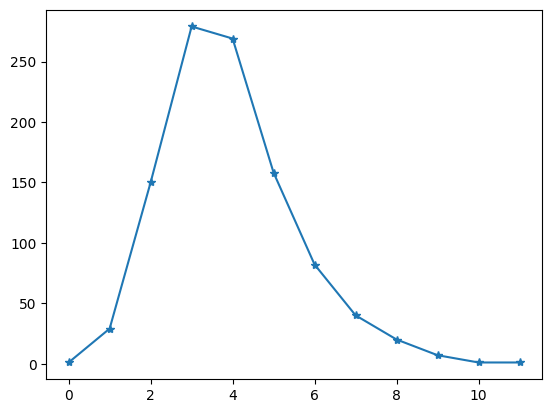

In [182]:
plt.plot(results, marker='*')

(array([[ 2.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 5.,  3., 10.,  6.,  4.,  0.,  0.,  0.,  0.,  0.],
        [ 2., 12., 10., 14.,  5.,  2.,  0.,  0.,  0.,  0.],
        [ 3., 15., 22., 21.,  5.,  3.,  0.,  0.,  0.,  0.],
        [ 4., 19., 47., 39.,  8.,  3.,  3.,  1.,  0.,  0.],
        [ 2., 24., 52., 48., 24., 13.,  5.,  0.,  0.,  0.],
        [ 4., 28., 51., 60., 37., 17.,  6.,  3.,  1.,  0.],
        [ 3., 31., 60., 47., 52., 28., 18.,  8.,  5.,  0.],
        [ 5., 14., 20., 31., 20., 15.,  8.,  8.,  1.,  2.],
        [ 0.,  1.,  6.,  3.,  3.,  1.,  0.,  0.,  0.,  0.]]),
 array([0.        , 0.12269916, 0.24539832, 0.36809748, 0.49079664,
        0.6134958 , 0.73619496, 0.85889413, 0.98159329, 1.10429245,
        1.22699161]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <matplotlib.collections.QuadMesh at 0x7f39c874fb20>)

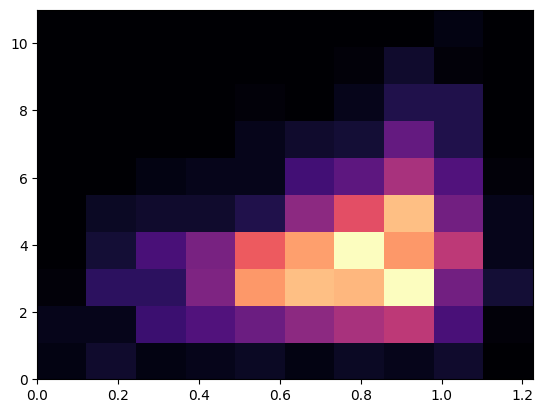

In [183]:
plt.hist2d(unique_times, unique_levenshteins, cmap='magma')

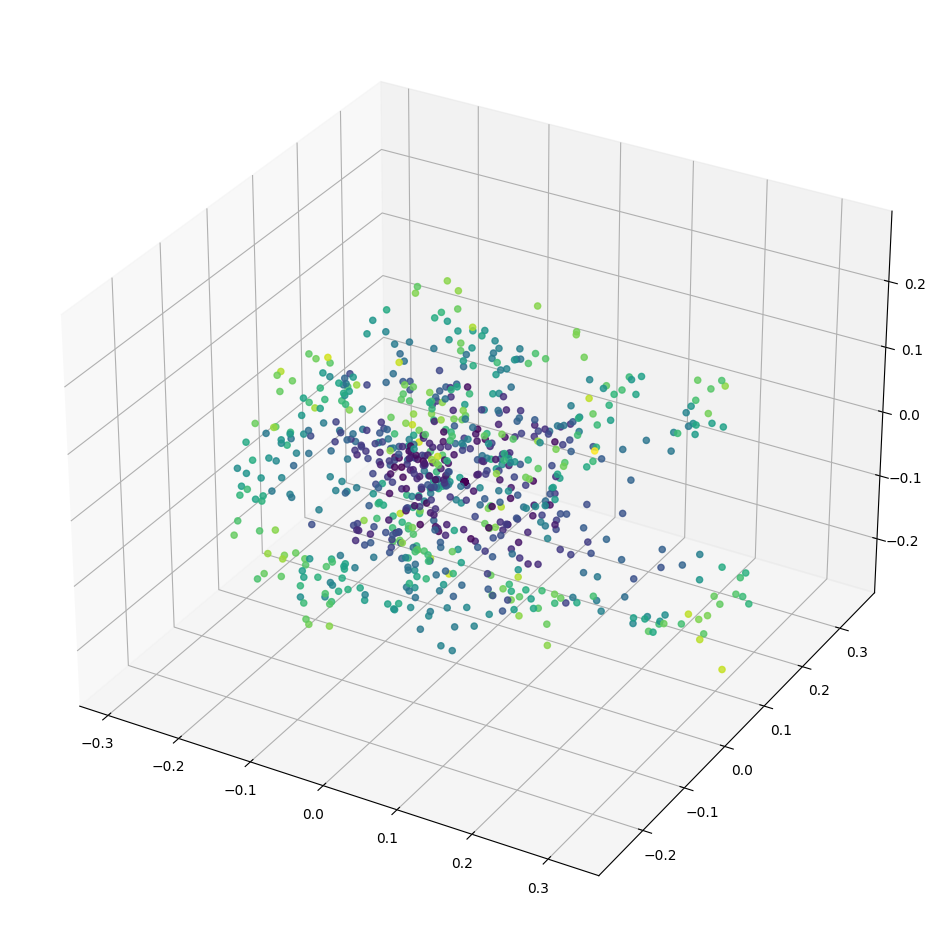

In [159]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


ax.scatter(
    trajectory_decomposition[:, 0],
    trajectory_decomposition[:, 1],  
    trajectory_decomposition[:, 2],
    c=all_times,
    alpha=0.8,
)

In [239]:
NB_OF_TRAJECTORIES = 100000
TRAJECTORIES = []


for _ in tqdm.tqdm(list(range(NB_OF_TRAJECTORIES))):
    current_point = starting_point
    trajectory = [current_point]

    for iter_ in range(ITERS):
        current_jacobian = decoder_jacobian(current_point)[0]
        #current_jacobian = torch.clip(current_jacobian, -1e3, 1e3)
        #print(current_jacobian)
        #print(current_jacobian.shape)
        U, S, V = torch.svd(current_jacobian)
        S_abs = torch.abs(S)
        #print(S_abs)
        dim = torch.sum(S_abs > THRESHOLD)
        trunc_s = S[S_abs > THRESHOLD]
        trunc_s_jac = torch.Tensor(S)
        trunc_s_jac[S <= THRESHOLD] = 0
        trunc_v = V[:, S_abs > THRESHOLD]
        #trunc_u = U[:, S_abs > THRESHOLD]
        trunc_jac = torch.matmul(torch.matmul(U, torch.diag(trunc_s_jac)), V.T)
        #print(torch.norm(trunc_jac - current_jacobian))
        euc_sphere_sample = sample_sphere_tensor(dim)
        riem_sphere_sample = euc_sphere_sample / trunc_s
        riem_sphere_sample_h = torch.zeros_like(S)
        riem_sphere_sample_h[S_abs > THRESHOLD] = riem_sphere_sample
        direction_sample = torch.matmul(riem_sphere_sample_h, V.T) * (dim ** 0.5) * EPS
        direction_sample = torch.clip(direction_sample, -STEP_CLIP, STEP_CLIP)
        field_acc = field_derivative(current_point, direction_sample)
        acc = torch.matmul(torch.linalg.pinv(trunc_jac), field_acc[0])
        acc = torch.clip(acc, -STEP_CLIP, STEP_CLIP)
        #print(torch.norm(direction_sample), torch.norm(acc), torch.norm(field_acc))
        next_point = current_point + direction_sample #- 0.5 * acc
        trajectory.append(next_point)
        current_point = next_point
        #break
    TRAJECTORIES.append(trajectory)


  0%|                                                                                                                                                                 | 41/100000 [00:02<1:23:41, 19.91it/s]


KeyboardInterrupt: 

In [176]:
tracs_trac_array = numpy.array(
    [   
        [
            el.cpu().detach().numpy()
            for el in trajectory
        ]
        for trajectory in TRAJECTORIES
    ]
)

In [177]:
tracs_trac_array.shape

(100000, 51, 2)

In [181]:
flattened = tracs_trac_array.reshape(-1, 2)

(array([2.46580e+06, 7.98475e+05, 6.31747e+05, 4.99440e+05, 3.59602e+05,
        2.14887e+05, 9.58350e+04, 2.91960e+04, 4.69500e+03, 3.23000e+02]),
 array([ 0.       ,  1.0013149,  2.0026298,  3.0039444,  4.0052595,
         5.006574 ,  6.007889 ,  7.009204 ,  8.010519 ,  9.011833 ,
        10.013148 ], dtype=float32),
 <BarContainer object of 10 artists>)

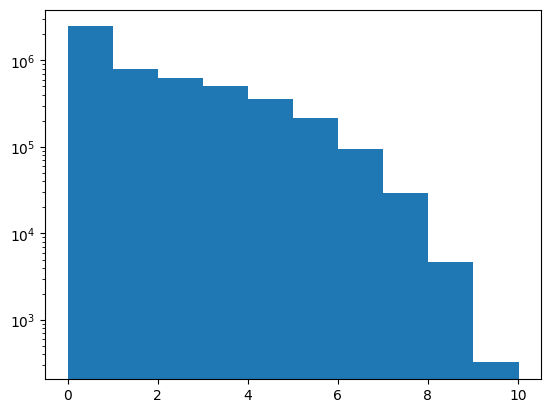

In [189]:
plt.hist(numpy.log1p(((flattened ** 2).sum(axis=1) ** 2)), log=True)

In [178]:
full_decompose = PCA()
full_decomposition = full_decompose.fit_transform(tracs_trac_array.reshape(tracs_trac_array.shape[0], -1))

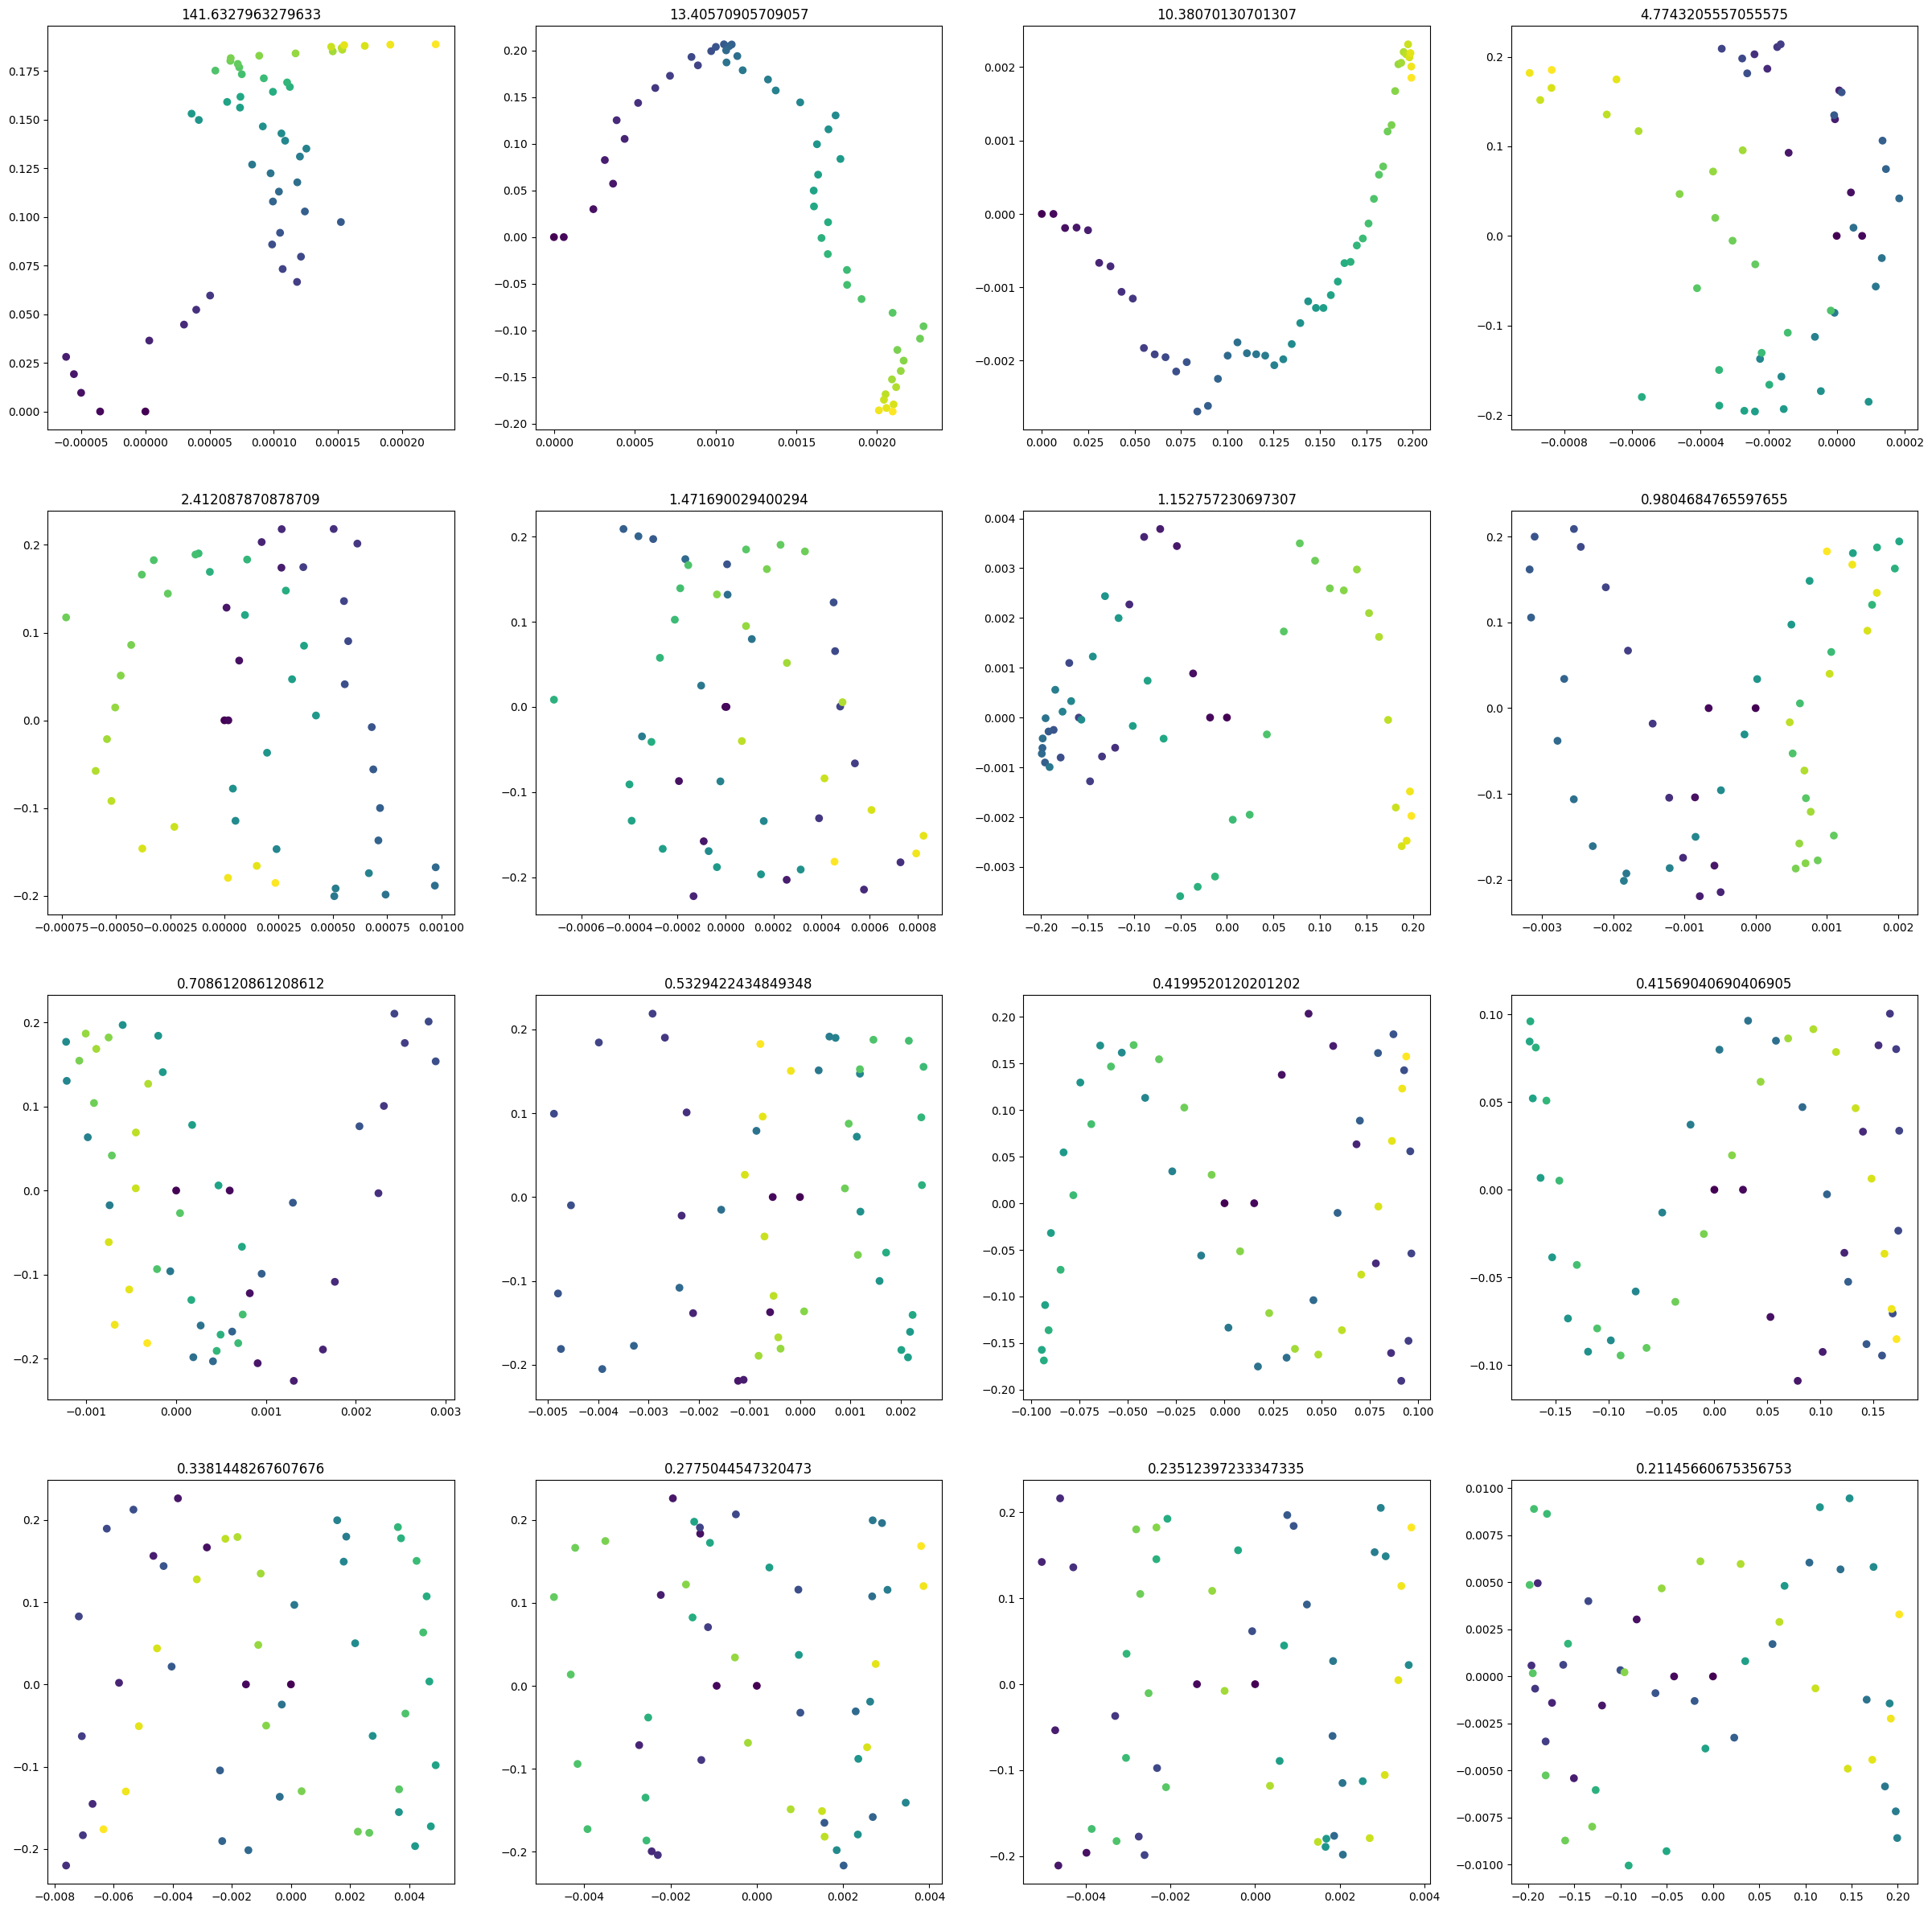

In [179]:
plt.figure(figsize=(30, 30))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    current_plot = full_decompose.components_[i].reshape((51, 2))
    plt.scatter(current_plot[:, 0], current_plot[:, 1], c=range(51))
    plt.title(full_decompose.explained_variance_[i])